In [33]:
import os
import numpy as np

# visualization
import matplotlib.pyplot as plt

# simple baseline (KNN)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# deep learning
import torch
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms

# custom 
from src.utils.general_utils import *
from src.data.TransformDataset import TransformDataset
from src.utils.train_utils import train

In [34]:
# set path to data folder
data_path = 'data'

### 1. Data exploration

The goal of this section is to get acquainted with the dataset. I am interested in the number, dimension and visual appearance of the samples in each of the 4 classes (desert, water, cloudy and green area).

#### 1.1. Check number of samples for each class

In [35]:
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} images")

desert: 1131 images
water: 1500 images
cloudy: 1500 images
green_area: 1500 images


#### 1.2. Check size of samples for each class

In [36]:
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name} image sizes: {get_img_sizes(class_path)}")

desert image sizes: [(256, 256)]
water image sizes: [(64, 64)]
cloudy image sizes: [(256, 256)]
green_area image sizes: [(64, 64)]


#### 1.3. Visualize samples

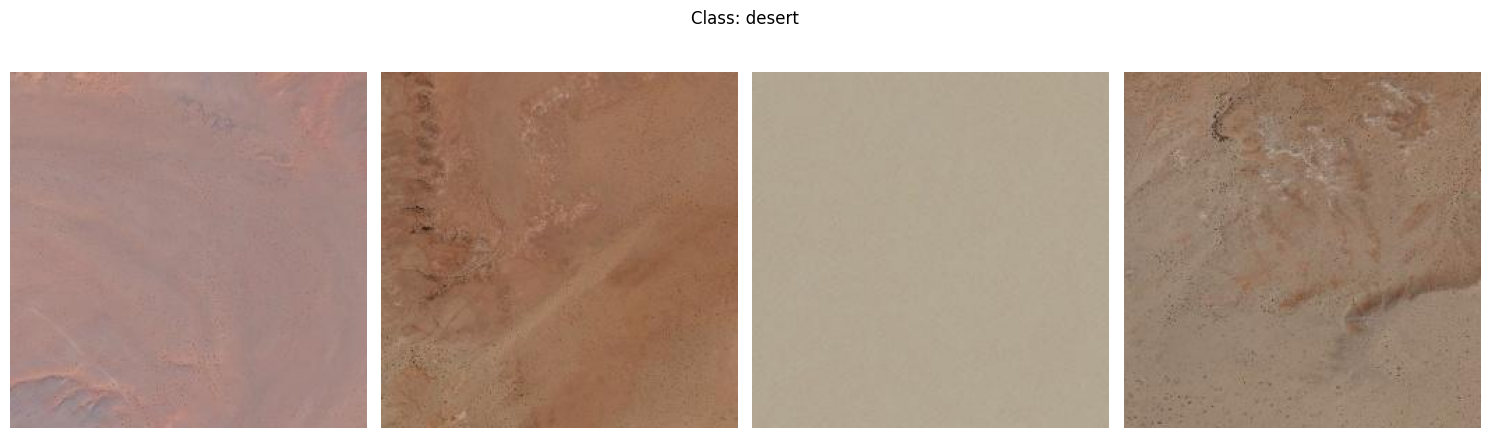

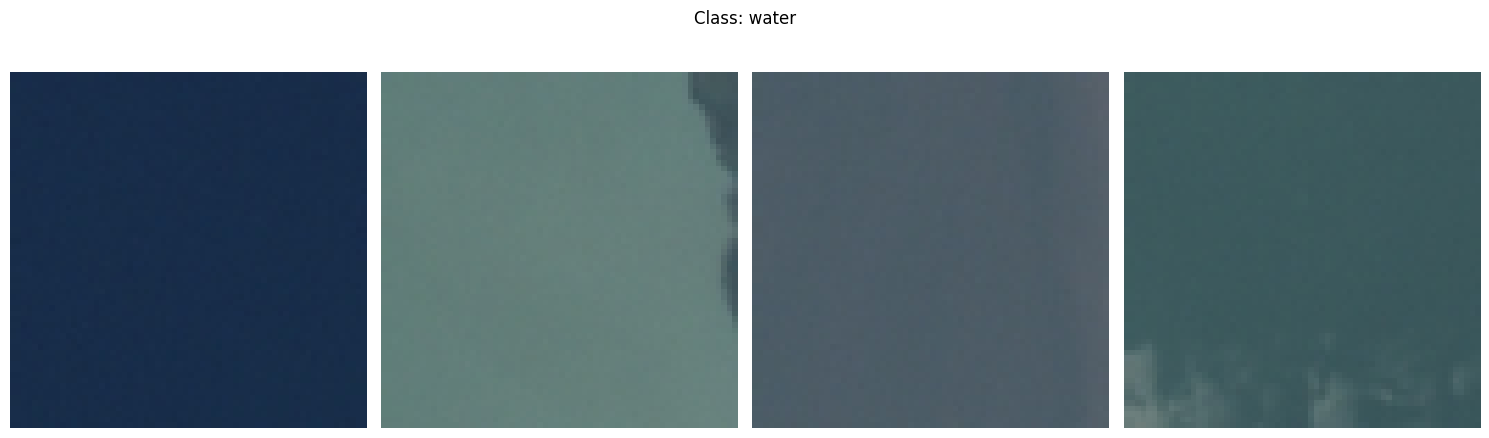

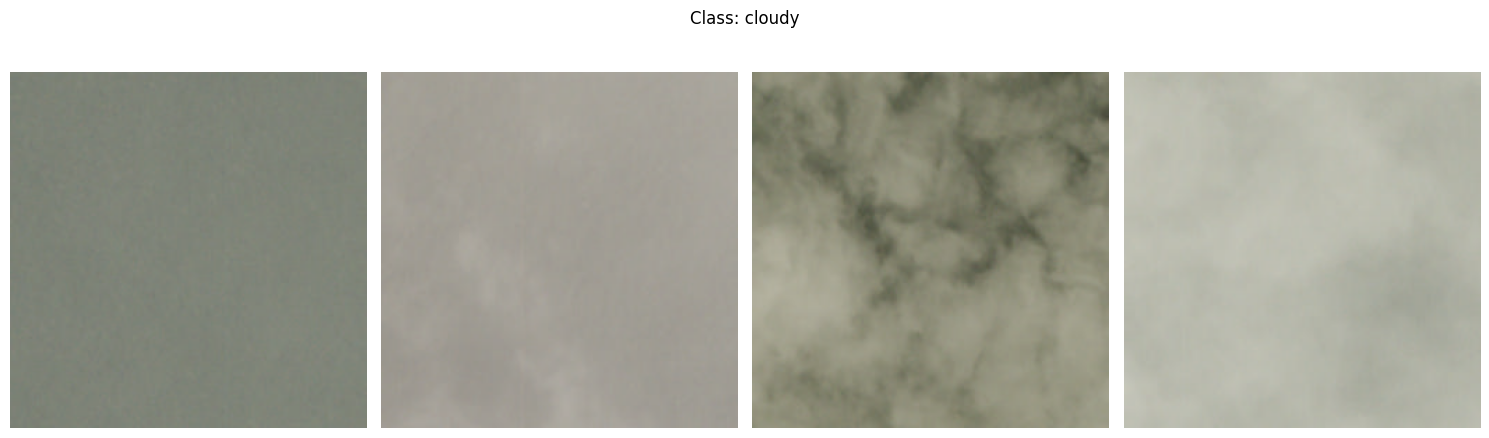

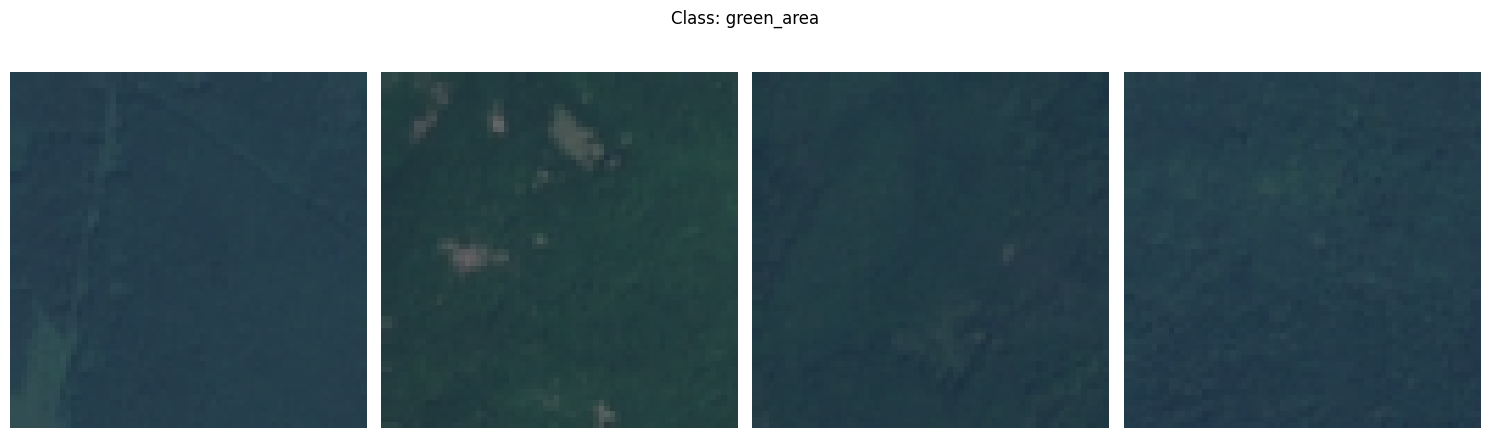

In [37]:
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        visualize_samples(class_path, class_name, num_samples=4)

### 2. Simple Baseline (KNN)

For the simple baseline, I've decided use K-Nearest Neighbours.

#### 2.1. Extract features

The first step is to extract some features from the satellite images using the custom `extract_features()` function. I've decided to extract the mean and the standard deviation of the pixel intensities for each channel, resulting in a total of 6 features. 

The function `extract_features()` can be found in `src/utils/general_utils.py`

In [38]:
# empty lists to store features and labels
features = []
labels = []
# extract features and labels
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        features.append(extract_features(img_path))
        labels.append(class_name)

#### 2.2. Fit K-Nearest Neighbours

In [39]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# train KNN model
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)

# evaluate model
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {knn.score(X_test, y_test)*100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

      cloudy       0.99      0.97      0.98       284
      desert       0.99      0.99      0.99       252
  green_area       0.93      1.00      0.96       288
       water       0.99      0.93      0.96       303

    accuracy                           0.97      1127
   macro avg       0.97      0.97      0.97      1127
weighted avg       0.97      0.97      0.97      1127

Accuracy: 96.98%


#### 2.3 Confusion Matrix

The confusion matrix provides an insight into which pairs of images might be harder to distinguish than others. Looking at it, we can notice that water can be sometimes misclassified as green area.

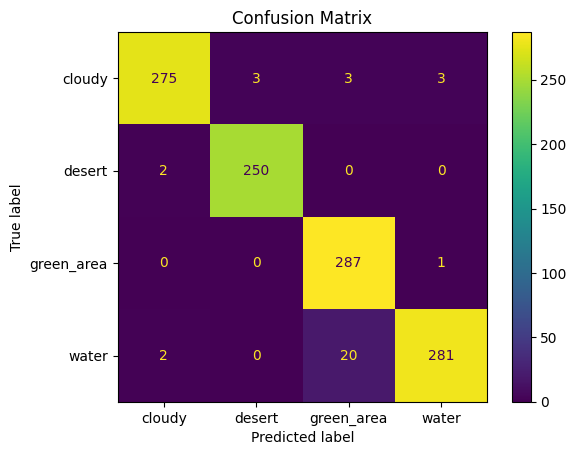

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=knn.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

#### 2.3. PCA for visualization

PCA is a technique for dimensionality reduction. Hence, I thought it would be interesting to apply it to the feature matrix (reduce it to 2 dimensions) and visualize the results.

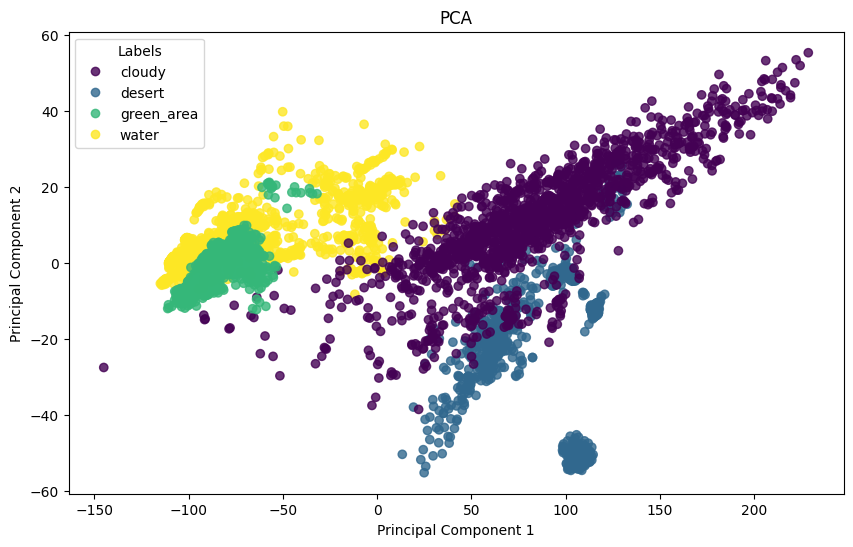

In [41]:
# convert labels to numeric values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels) 

# PCA
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features)

# plot the reduced features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    features_reduced[:, 0],
    features_reduced[:, 1],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.8
)
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, label_encoder.classes_, title="Labels")

# add titles and axis labels
plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### 3. Deep learning 

For the complex method, I've decided to use deep learning. Precisely, a small convolutional neural network.

#### 3.1. Prepare transforms, dataset and dataloaders

In [42]:
# prepare train transform
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# prepare test transform
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [43]:
# prepare dataset
dataset = datasets.ImageFolder(data_path)

# split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# apply transforms
train_dataset = TransformDataset(train_dataset, transform=train_transform)
test_dataset = TransformDataset(test_dataset, transform=test_transform)

# prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

#### 3.2. Prepare model, criterion and optimizer

In [44]:
# prepare model
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(8 * 16 * 16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 4)
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params:,}")

# prepare loss function
criterion = torch.nn.CrossEntropyLoss()

# prepare optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Number of parameters: 67,308


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=4, bias=True)
)

#### 3.3 Train the model

In [45]:
train_losses, validation_losses, best_validation_accuracy = train(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30
)

Epoch 1: train_loss=0.5727204371851387, val_loss=0.3468601434595055, val_accuracy=0.874889075756073
Epoch 2: train_loss=0.3631702280002283, val_loss=0.2879482373181317, val_accuracy=0.8855368494987488
Epoch 3: train_loss=0.2874592154795396, val_loss=0.2483818040539821, val_accuracy=0.9094942212104797
Epoch 4: train_loss=0.25050916559730013, val_loss=0.2502879167182578, val_accuracy=0.9023957252502441
Epoch 5: train_loss=0.231100857891935, val_loss=0.20846653724503186, val_accuracy=0.9272404909133911
Epoch 6: train_loss=0.22211952293489842, val_loss=0.23216146375570032, val_accuracy=0.9157053828239441
Epoch 7: train_loss=0.20369436528454435, val_loss=0.20681694631154338, val_accuracy=0.9228038787841797
Epoch 8: train_loss=0.2051825505938936, val_loss=0.2100567963336491, val_accuracy=0.9192546606063843
Epoch 9: train_loss=0.19954375416727355, val_loss=0.18556871679094103, val_accuracy=0.9343389272689819
Epoch 10: train_loss=0.19890646396059516, val_loss=0.1994900041156345, val_accuracy=0

#### 3.4 Plot the Train and Validation / Test Losses

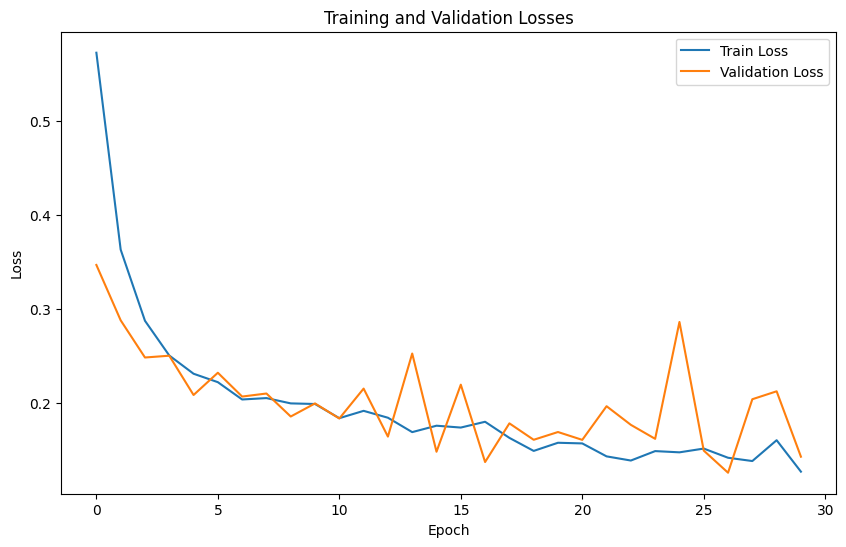

In [46]:
# plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
print("Validation accuracy: {:.2f}%".format(best_validation_accuracy * 100))

Validation accuracy: 96.27%
